In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
print(tf.__version__)

2.0.0


In [3]:
def data_processing(file_name, file_name_D):
    """
    Read the csv files and create game characterstic features and player statistic features
    """
    df = pd.read_csv(file_name)
    df_D = pd.read_csv(file_name_D)
    df.sort_values(by = ['Name', 'Unnamed: 2_level_0 G#']) # for rolling average
    # All box score player stats, except defensive statistics
#     stats = ['Passing AY/A', 'Passing Att', 'Passing Cmp', 'Passing Cmp%',
#             'Passing Int', 'Passing Rate','Passing Yds','FPoints']
    stats = ['Passing Yds','FPoints']
    # Opponent Characteristics
    df, opp_features = get_opp_d(df, df_D)
    # Game Characteristic Indicators, e.g. home/away, opponent, team
#     df, game_features = get_game_char_indicators(df)
    # Player Statistic Features, e.g. Season, last 4 weeks, previous week
    df, player_features = get_player_averages(df, stats)
#     features = game_features + player_features
#     features = player_features
    features = player_features + opp_features
    df = df.fillna(0)
    return df, features


def get_game_char_indicators(df):
    """
    Transform str cols into game categorical variables
    Returns transformed and columns
    """
    df['home'] = 1 * df['Unnamed: 6_level_0 Unnamed: 6_level_1'] == '0'
    oppts = pd.get_dummies(df['Unnamed: 7_level_0 Opp'], prefix='Oppt')
    teams = pd.DataFrame()
    team_list = pd.Series('ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET',\
                           'GB', 'HOU', 'IND', 'JAC', 'KC', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ',\
                           'OAK', 'PHI', 'PIT', 'SD', 'SEA', 'SF', 'STL', 'TB', 'TEN', 'WAS')
    for team in df['Unnamed: 5_level_0 Tm']:
        temp = (team_list == team)
        teams = teams.append(temp, ignore_index=True)
    teams.index = range(len(df['Unnamed: 5_level_0 Tm']))
    teams.columns = list(team_list)
    df = pd.concat([df, oppts, teams], axis=1)
    return df, ['home'] + list(oppts.columns) + list(team_list)

def get_opp_d(df, df_D):

    d_stats = ['Passing Yds', 'Passing 1stD','Sc%','Unnamed: 26_level_0 TO%']
    df_D['Season']= df_D['Season'].astype(str)
#     for stat in df[d_stats + ['FPoints']]:
#         opp = abbrev_dict[df['Unnamed: 7_level_0 Opp']]
#         df['D_'+stat] = df_D.loc[df_D['Tm'] == opp][stat]
    for stat in d_stats:
#         print(stat)
        df[stat] = df.apply(lambda row: get_team_stat(row,stat,df_D), axis=1)
    return df, d_stats
def get_team_stat(row,stat,df_D):
    abbrev_dict = {'ARI':'Arizona Cardinals', 'ATL':'Atlanta Falcons', 'BAL':'Baltimore Ravens', 'BUF':'Buffalo Bills', 
                          'CAR':'Carolina Panthers', 'CHI':'Chicago Bears', 'CIN':'Cincinnati Bengals', 
                          'CLE':'Cleveland Browns', 'DAL':'Dallas Cowboys', 'DEN':'Denver Broncos', 'DET':'Detroit Lions', 
                          'GB':'Green Bay Packers','GNB':'Green Bay Packers', 'HOU': 'Houston Texans', 'IND':'Indianapolis Colts', 
                          'JAC':'Jacksonville Jaguars', 'JAX':'Jacksonville Jaguars','KAN':'Kansas City Chiefs','KC':'Kansas City Chiefs','LAC':'Los Angeles Chargers',
                          'LAR':'Los Angeles Rams', 'MIA':'Miami Dolphins', 'MIN':'Minnesota Vikings','NE':'New England Patriots','NWE':'New England Patriots',
                          'NO':'New Orleans Saints','NOR':'New Orleans Saints', 'NYG':'New York Giants', 'NYJ':'New York Jets','OAK':'Oakland Raiders', 
                          'PHI':'Philadelphia Eagles', 'PIT':'Pittsburgh Steelers', 'SD':'San Diego Chargers', 'SDG':'San Diego Chargers', 'SEA':'Seattle Seahawks', 
                          'SF':'San Francisco 49ers', 'SFO':'San Francisco 49ers','STL':'St. Louis Rams', 'TB':'Tampa Bay Buccaneers',
                           'TEN':'Tennessee Titans', 'TAM':'Tampa Bay Buccaneers',
                          'WAS':'Washington Redskins'}
#     print(row)
#     print(df_D['Season'])
    df_D.index=df_D['Tm']+df_D['Season']
#     print(df_D)
    opp = abbrev_dict[row['Unnamed: 7_level_0 Opp']]+str(row['Season'])
#     print(type(df_D.loc[df_D['Tm']==opp][stat]))
#     print(opp,stat)
    return df_D.at[opp,stat]

def rolling_average(df, window):
    return df.rolling(min_periods=1, window=window).mean().shift(1)

def get_player_averages(df, stats):
    """
    Estimate player averages for all stats and FanDuel point histories,
    for season-to-date, last 4 weeeks, and previous week
    """
    feature_names = []
    for stat in df[stats + ['FPoints']]:
        df['season_{}'.format(stat)] = df.groupby('Name')[stat].apply(lambda x: rolling_average(x, 16))
        df['recent_{}'.format(stat)] = df.groupby('Name')[stat].apply(lambda x: rolling_average(x, 4))
        df['prev_{}'.format(stat)] = df.groupby('Name')[stat].apply(lambda x: rolling_average(x, 1))
        feature_names = feature_names + [time + "_" + stat for time in ['season', 'recent', 'prev']]
    return df, feature_names


path = "data/"
train, features = data_processing(path + 'QB_all.csv', path + 'teams_all.csv')
# test, features2 = data_processing(path + 'gamelog_QB_2018.csv', path + 'teams_2018.csv')
# if (features != features2):
#     print("Debug error about feature inconsistency")
#     exit()

In [4]:
train.to_csv('train.csv')

In [5]:
features.append('FPoints')
# features.remove('home')
features.remove('season_FPoints')
features.remove('recent_FPoints')
features.remove('prev_FPoints')
# print(features)
dataset = train[features]
# dataset
train_dataset = dataset.sample(frac=0.8,random_state=0)
# print(train_dataset)
test_dataset = dataset.drop(train_dataset.index)
train_stats = train_dataset.describe(include='all')
train_stats.pop('FPoints')
train_stats = train_stats.transpose()
# train_stats

['season_Passing Yds', 'recent_Passing Yds', 'prev_Passing Yds', 'season_FPoints', 'recent_FPoints', 'prev_FPoints', 'Passing Yds', 'Passing 1stD', 'Sc%', 'Unnamed: 26_level_0 TO%', 'FPoints']


,count,mean,std,min,25%,50%,75%,max
season_Passing Yds,4705.0,3577.187646,597.565648,0.00,3510.0000,3671.7500,3816.875,4681.000
recent_Passing Yds,4705.0,3590.444757,614.186345,0.00,3489.0000,3674.5000,3857.250,4681.000
prev_Passing Yds,4705.0,3596.502657,687.417622,0.00,3382.0000,3688.0000,3949.000,4796.000
season_FPoints,4705.0,14.193563,4.887679,-1.52,11.6525,14.5225,17.385,30.680
recent_FPoints,4705.0,14.280995,5.692056,-1.52,10.9700,14.5400,17.945,31.335
prev_FPoints,4705.0,14.275439,8.331501,-6.60,8.5000,14.2000,19.640,49.320
Passing Yds,4705.0,3683.977683,393.646384,2459.00,3423.0000,3697.0000,3947.000,4796.000
Passing 1stD,4705.0,189.320935,20.182076,128.00,176.0000,189.0000,201.000,247.000
Sc%,4705.0,33.928948,4.976659,20.30,30.4000,33.7000,37.800,46.400
Unnamed: 26_level_0 TO%,4705.0,12.367120,3.048711,3.90,10.2000,12.4000,14.300,21.000


In [6]:
train_labels = train_dataset.pop('FPoints')
test_labels = test_dataset.pop('FPoints')
train_labels

840     19.28
3161     0.00
3065    12.24
3067    16.92
3924    15.26
        ...  
3436    11.50
4256     0.00
5692    17.16
5612     7.34
5308    13.50
Name: FPoints, Length: 4705, dtype: float64

In [70]:
def build_model():
#     model = keras.Sequential([
#         layers.Dense(8, activation='tanh', input_shape=[len(train_dataset.keys())]),
# #         layers.Dense(16, activation='relu'),
#         layers.Dense(1)
#     ])


    model=keras.Sequential()
#     model.add(layers.Dense(64,input_shape=[len(train_dataset.keys())]))
    model.add(layers.Dense(16,input_shape=[len(train_dataset.keys())]))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.Dense(16,input_shape=[len(train_dataset.keys())]))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.Dense(1))

    optimizer = tf.keras.optimizers.RMSprop(0.07)

    model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
    return model
model = build_model()

In [71]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [72]:
example_batch = normed_train_data[:10]
example_batch

,season_Passing Yds,recent_Passing Yds,prev_Passing Yds,season_FPoints,recent_FPoints,prev_FPoints,Passing Yds,Passing 1stD,Sc%,Unnamed: 26_level_0 TO%
840,0.042777,0.020035,-0.312041,-0.539840,-0.478912,-1.362952,-1.183747,-1.056429,-1.733884,2.831649
3161,0.169646,0.201983,0.522968,-0.570529,-0.387557,-0.517967,-0.007564,-0.660038,-0.508162,-0.678031
3065,0.658191,0.618795,0.789182,0.609990,0.508429,0.679897,0.706274,-0.015902,-1.291820,1.093209
3067,0.537423,0.551633,-0.073467,0.405735,0.439912,0.221396,2.418471,2.461544,-0.246942,0.962007
3924,0.702328,0.596407,0.118556,0.822003,1.691657,1.265626,-0.121880,-0.858234,0.556810,-2.219666
5176,-0.029600,0.136449,-0.552070,-0.766941,-0.116126,0.298213,0.000057,-0.015902,0.456341,-1.793256
842,-0.016770,0.061553,0.258209,-0.053924,-0.189034,0.456648,0.617362,0.727332,-0.046004,-0.546828
1789,0.025311,0.149068,0.620434,0.488256,0.378423,1.030374,2.588674,2.758837,-0.267036,1.552420
3768,0.347869,0.578090,0.384770,1.285157,1.240150,-0.722011,0.967930,0.132745,-0.427787,-0.087617
2030,0.152640,0.163721,0.146195,-1.538064,-1.121914,-0.923656,-0.972898,-1.155527,0.396059,-1.137241


In [73]:
example_result = model.predict(example_batch)
example_result

array([[-1.1687758 ],
       [-0.00868736],
       [-0.96535975],
       [-0.38398603],
       [-0.8422428 ],
       [ 0.34834462],
       [ 0.02119172],
       [-0.6438642 ],
       [-0.9199188 ],
       [-0.09226994]], dtype=float32)

In [74]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

print(normed_train_data.shape, train_labels.shape)

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

(4705, 10) (4705,)

....................................................................................................

In [75]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,56.069976,6.002429,56.069973,52.396615,5.713422,52.396614,95
96,56.075322,6.030626,56.075302,52.999971,5.724544,52.999966,96
97,56.068782,6.022595,56.068779,58.809057,5.987381,58.809063,97
98,55.997938,6.018279,55.997936,54.138871,5.789670,54.138870,98
99,55.962042,6.010502,55.962051,54.308675,5.762369,54.308670,99


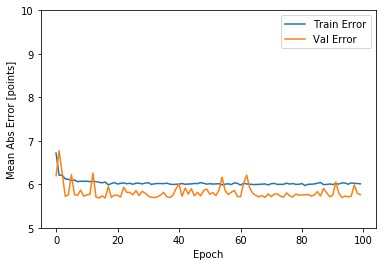

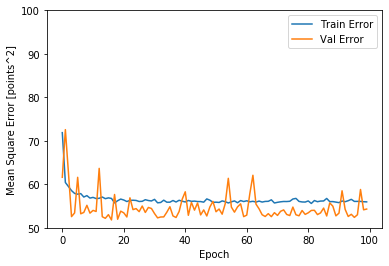

In [76]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [points]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([5,10])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [points^2]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([50,100])
  plt.legend()
  plt.show()
plot_history(history)


...........................

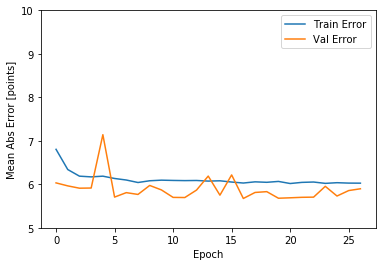

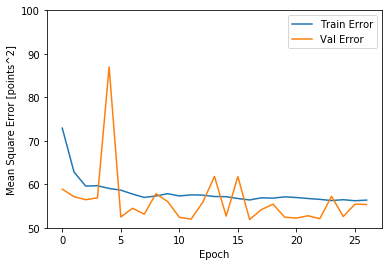

In [77]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [78]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} points".format(mae))

1176/1176 - 0s - loss: 60.9318 - mae: 6.2402 - mse: 60.9318
Testing set Mean Abs Error:  6.24 points


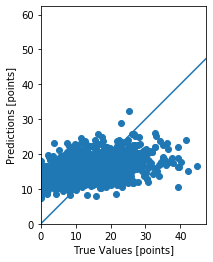

In [79]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [points]')
plt.ylabel('Predictions [points]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

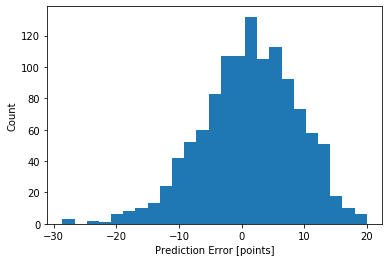

In [80]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [points]")
_ = plt.ylabel("Count")